# Similarity Modeling 1/2: Recognizing Waldorf & Statler

## Required libraries and installs

In [1]:
!cat requirements-dl-audio.txt
!pip install -r requirements-fe-audio.txt

pandas
numpy
opencv-python
librosa==0.9.2
tqdm
tensorflow==2.9.2
matplotlib==3.1.3


In [18]:
#!brew install ffmpeg # MacOS (tested)
#!sudo apt install ffmpeg # Ubuntu (not tested)

Running `brew update --auto-update`...
==> Auto-updated Homebrew!
Updated 3 taps (homebrew/core, homebrew/cask and homebrew/services).
==> New Formulae
ansible@6       marksman        prowler         steampipe       syft
lemmeknow       protolint       sniffnet        stepci
==> New Casks
attachecase                menubarx                   vk-calls
iconchanger                virtual-desktop-streamer   youtype

You have 4 outdated formulae installed.
You can upgrade them with brew upgrade
or list them with brew outdated.

==> Fetching dependencies for ffmpeg: highway, imath, openexr, xz, jpeg-xl, libvmaf, aom, dav1d, frei0r, gmp, bdw-gc, m4, libtool, libunistring, guile, libidn2, libtasn1, nettle, p11-kit, libevent, unbound, gnutls, lame, pcre2, glib, libxrender, libunibreak, libass, libbluray, cjson, cmocka, mbedtls, librist, libsoxr, libvidstab, libogg, libvorbis, libvpx, opencore-amr, opus, rav1e, flac, mpg123, libsndfile, libsamplerate, rubberband, sdl2, snappy, speex, srt, theora

## Imports

In [2]:
import os
import glob
import pathlib

import pandas as pd
import numpy as np

import cv2 as cv2
import matplotlib.pyplot as plt

## Constants

In [6]:
# path to ground truth and videos
DATA_PATH = "../data/"
GROUND_TRUTH_PATH = os.path.join(DATA_PATH, "sim12-ground-truth-muppets")
VIDEO_PATH = os.path.join(DATA_PATH, "video")
AUDIO_PATH = os.path.join(DATA_PATH, "audio")

# Project Structure

In [7]:
if not os.path.exists(AUDIO_PATH):
    os.makedirs(AUDIO_PATH)

# 1. Data Preparation

## 1.1 List all videos

In [8]:
videos = glob.glob(VIDEO_PATH + '/*.avi')

videos_tmp = []
for video in videos:
    videos_tmp.append(pathlib.Path(video).name)
videos = videos_tmp

videos

['Muppets-02-01-01.avi', 'Muppets-03-04-03.avi', 'Muppets-02-04-04.avi']

## 1.2 Read ground truth from CSV

In [9]:
ground_truth = dict()

# read in corresponding ground truth
for video in videos:
        file_name = glob.glob(GROUND_TRUTH_PATH + '/*' + os.path.splitext(video)[0] + '*.csv')
        csv = pd.read_csv(os.path.join(file_name[0]), sep=";")
        ground_truth[video] = csv

## 1.3 Plot the ground truth

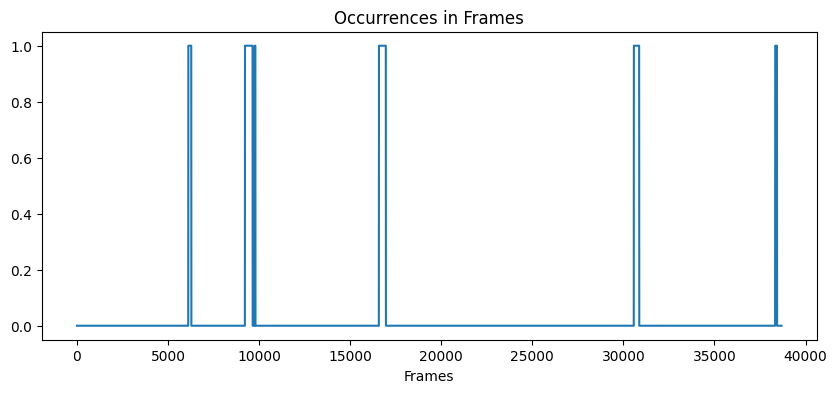

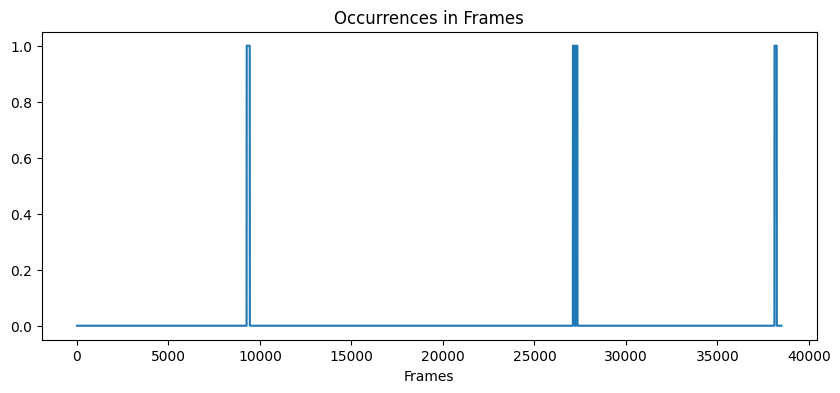

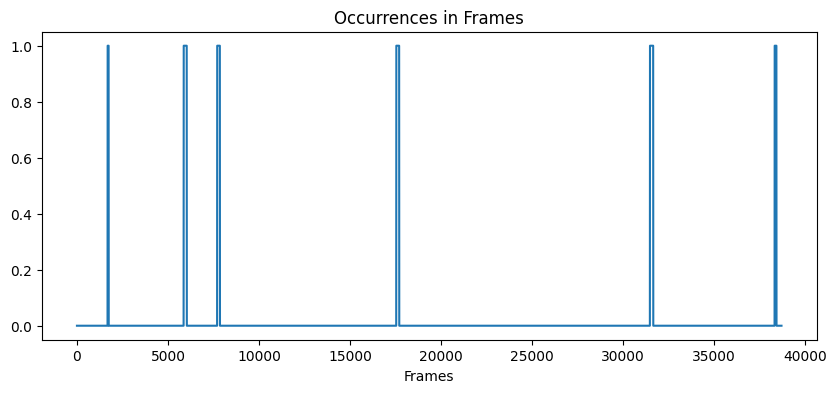

In [11]:
def plot_gt(gt, column):
    plot = plt.figure(figsize=(10, 4))

    # define subplot
    subplot = plot.add_subplot(111)
    subplot.set_title(f"Occurrences in Frames")

    # define x axis
    subplot.set_xlabel('Frames')

    # mark occurrences
    frame_indicator = np.zeros(len(gt['Frame_number']))
    frame_indicator[gt[gt[column] == 1].index] = 1

    subplot.plot(gt[column].index, frame_indicator)
    plt.show()

for video in videos:
    plot_gt(ground_truth[video], "Audio_StatlerWaldorf")

## 1.4 Load video data

In [12]:
video_data = dict()

for video in videos:
        file_name = glob.glob(VIDEO_PATH + '/*' + os.path.splitext(video)[0] + '*.avi')
        video_cap = cv2.VideoCapture(os.path.join(file_name[0]))
        video_data[video] = video_cap

## 1.5 FPS Constant

In [13]:
FPS = 25

## 1.6 Combine data frames, filter for Waldorf & Statler and add seconds

In [40]:
df_gt = pd.concat(ground_truth)

df_gt["Seconds"] = df_gt["Frame_number"] / FPS
df_gt = df_gt[["Video", "Frame_number", "Seconds", "Audio_StatlerWaldorf"]]
df_gt.head()

Video  Frame_number  Seconds  Audio_StatlerWaldorf
Muppets-02-01-01.avi 0    211             0     0.00                     0
                     1    211             1     0.04                     0
                     2    211             2     0.08                     0
                     3    211             3     0.12                     0
                     4    211             4     0.16                     0

## 1.7 Mapping Filename - Video

In [42]:
video2filename = {"Muppets-02-01-01.avi" : 211, "Muppets-02-04-04.avi" : 244,"Muppets-03-04-03.avi" : 343}

## 1.8 Convert .avi to .wav

In [44]:
for video in videos:
        file_name_video = glob.glob(VIDEO_PATH + '/*' + os.path.splitext(video)[0] + '*.avi')[0]
        file_name_audio = os.path.join(AUDIO_PATH, os.path.splitext(video)[0] + '.wav')
        command2wav = f"ffmpeg -i {file_name_video} {file_name_audio}"

        os.system(command2wav)

        # save audio filename to data frame
        df_gt.loc[df_gt["Video"] == video2filename[os.path.splitext(video)[0] + ".avi"], "file_name_audio"] = os.path.splitext(video)[0] + ".wav"

df_gt.head()

ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 14.0.0 (clang-1400.0.29.202)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/5.1.2_1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --disable-indev=jack --enable-videotoolbo

Video  Frame_number  Seconds  Audio_StatlerWaldorf  \
Muppets-02-01-01.avi 0    211             0     0.00                     0   
                     1    211             1     0.04                     0   
                     2    211             2     0.08                     0   
                     3    211             3     0.12                     0   
                     4    211             4     0.16                     0   

                             file_name_audio  
Muppets-02-01-01.avi 0  Muppets-02-01-01.wav  
                     1  Muppets-02-01-01.wav  
                     2  Muppets-02-01-01.wav  
                     3  Muppets-02-01-01.wav  
                     4  Muppets-02-01-01.wav